# Lab 3

## Part 1: The Invariant Mass Distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

atlas_data = np.loadtxt('atlas_z_to_ll.csv', delimiter = ',', skiprows = 1).T



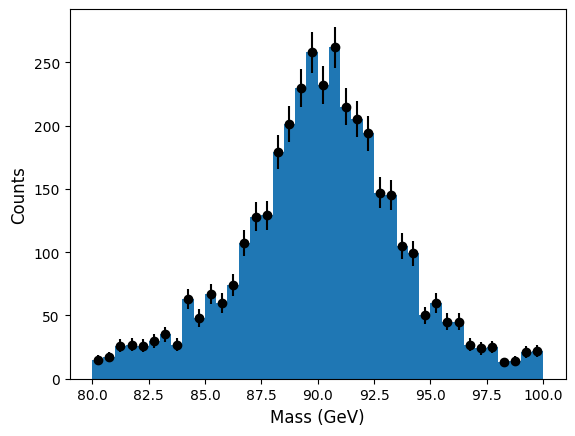

In [2]:
def momenta_components(pT, eta, phi):
    # givens momenta components according to formulas
    px = pT*np.cos(phi)
    py = pT*np.sin(phi)
    pz = pT*np.sinh(eta)
    return [px, py, pz]

P1 = momenta_components(atlas_data[0], atlas_data[2], atlas_data[4]) # momenta of particle 1
P2 = momenta_components(atlas_data[1], atlas_data[3], atlas_data[5]) # momenta of particle 2

Ptot = np.full_like(P1, 0)

# we're gonna make an array to fill with values of the total momentum of the two particles
# since the shape of the array makes them hard to add straightforwardly

for i in range(len(Ptot[0])):
    Ptot[0][i] += P1[0][i] + P2[0][i]
    Ptot[1][i] = P1[1][i] + P2[1][i]
    Ptot[2][i] = P1[2][i] + P2[2][i]

Etot_sq = (atlas_data[-2] + atlas_data[-1])**2 # total energy squared

Ptot_sq = np.full_like(Etot_sq, 0)

for i in range(len(Etot_sq)):
    Ptot_sq[i] += Ptot[0][i]**2 + Ptot[1][i]**2 + Ptot[2][i]**2 # squaring all components of total momentum and adding

M = np.sqrt(Etot_sq - Ptot_sq) # using formula for mass from energy, momentum

fig, ax = plt.subplots()
bins = np.linspace(80,100,41)
counts, bin_edges, patches = ax.hist(M, bins = bins)
error = np.full_like(counts, 0)
for i in range(len(error)):
    error[i] += np.sqrt(counts[i])

bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

ax.errorbar(bin_centers, counts, error, fmt = 'ko')
ax.set_xlabel("Mass (GeV)", fontsize = 12)
ax.set_ylabel("Counts", fontsize = 12);



## Part 2: Breit-Wigner Fit

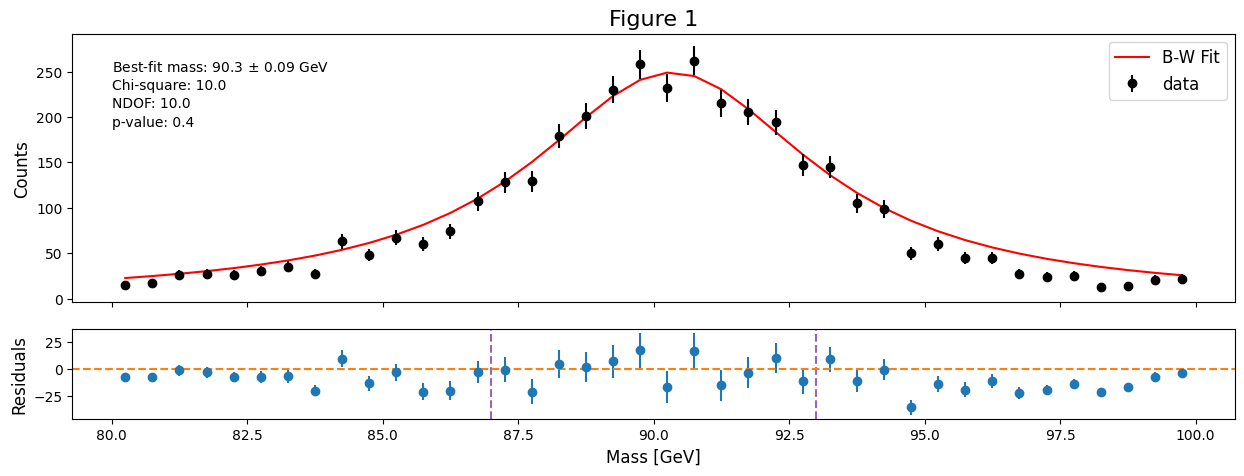

In [3]:
from scipy.optimize import curve_fit
import scipy.stats as st

def BW(m, m0, gamma):
    return (2500/np.pi)*((gamma/2)/((m-m0)**2 + (gamma/2)**2)) # defines B-W distribution * 2500 which is 5000/2
    # since we need to adjust the normalization of the distribution

mask = (bin_centers > 87) & (bin_centers < 93) # masking the data values to make a better fit around the center


params, covar = curve_fit(f = BW, xdata = bin_centers[mask], ydata = counts[mask], sigma = error[mask], absolute_sigma = True)

ytheory = BW(bin_centers, *params) # fitted B-W on imput masses
ydata = counts # actual data values

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, sharex = True, figsize = (15,5), gridspec_kw = {"height_ratios":[3,1], "hspace":0.15})

ax_top.plot(bin_centers, BW(bin_centers, *params), color = 'red', label = "B-W Fit")
ax_top.errorbar(bin_centers, counts, error, fmt = 'ko', label = "data")
ax_bot.set_xlabel("Mass [GeV]", fontsize = 12)
ax_top.set_ylabel("Counts", fontsize = 12)
ax_bot.set_ylabel("Residuals", fontsize = 12)
ax_bot.axvline(87, ls = '--', color = "C4")
ax_bot.axvline(93, ls = '--', color = "C4")
ax_top.legend(fontsize = 12)


residuals = ydata - ytheory

ax_bot.errorbar(bin_centers, residuals, yerr = error, fmt = 'o')
ax_bot.axhline(0, ls = '--', color = 'C1')

# We only want chisq in fitting range, so first we apply the mask

fitting_data = counts[mask]
fitting_theory = BW(bin_centers[mask], *params)

chi_sq = ((fitting_data - fitting_theory)**2/(error[mask])**2).sum()

# To calculate reduced chisq, we need to determine dof. There are two fitting parameters.
# We only need to include the number of points used in the fit. This means using the masked data

dof = len(counts[mask]) - 2  # number of points - 2

red_chi_sq = chi_sq/dof 

pval = st.chi2.sf(chi_sq, dof)

m0 = params[0]
m0_err = np.sqrt(covar[0][0]) # covar[0][0] is sigma^2

ax_top.set_title("Figure 1", fontsize = 16);

ax_top.annotate(f"Best-fit mass: {m0:.1f} $\pm$ {m0_err:.2f} GeV", (80,250))
ax_top.annotate(f"Chi-square: {chi_sq:.1f}", (80,230))
ax_top.annotate(f"NDOF: {dof:.1f}", (80,210))
ax_top.annotate(f"p-value: {pval:.1f}", (80,190));

fig.savefig("Figure1.png")


## Part 3: 2D Parameter Contours

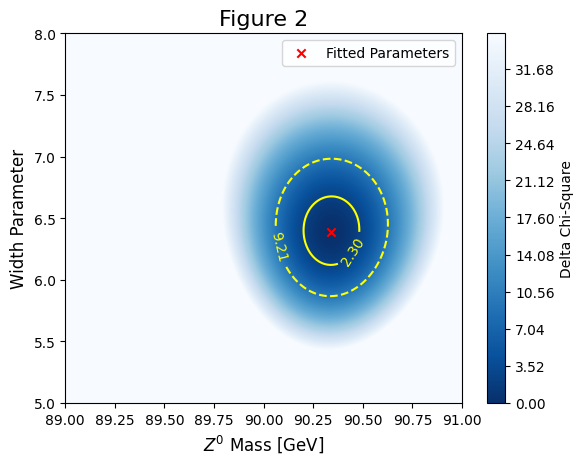

In [4]:
# Again, we use the masked data arrays for this analysis, since our fit was based on
# the masked data

n_bins = 300
M0 = np.linspace(89,91,n_bins) # creating array of Z0 mass values
Gamma = np.linspace(5,8,n_bins) # creating array of width values
chi_map = np.zeros((n_bins, n_bins)) # we will fill this array with the chi2 values at each grid point

for i in range(n_bins):
    for j in range(n_bins):
        theory = BW(bin_centers[mask], M0[i], Gamma[j])
        chi2 = np.sum((theory - ydata[mask])**2/error[mask]**2)
        chi_map[j,i] = chi2 # filling the array

chi_min = np.min(chi_map)
chi_map = np.clip(chi_map, chi_min, chi_min + 35) # clipping the plot to make it easier to visualize
delta_chi_map = chi_map - chi_min # delta chi2 for each point

X,Y = np.meshgrid(M0,Gamma)
fig2, ax2 = plt.subplots(1,1)
cs = ax2.contourf(X,Y, delta_chi_map, 500, cmap = "Blues_r")
cbar = fig2.colorbar(cs, ax = ax2)
cbar.set_label("Delta Chi-Square")
ax2.scatter(params[0], params[1], marker = 'x', color = 'red', label = 'Fitted Parameters')
ax2.set_xlabel("$Z^0$ Mass [GeV]", fontsize = 12)
ax2.set_ylabel("Width Parameter", fontsize = 12)
ax2.set_title("Figure 2", fontsize = 16)


levels = [2.3, 9.21] # levels for a 2-parameter fit obtained from Lecture 22
CS = ax2.contour(X,Y,delta_chi_map, levels = levels, colors = ["yellow", "yellow"],
                linestyles = ["solid", "dashed"])
ax2.clabel(CS, fontsize=10); # setting the contour labels
ax2.legend()

fig2.savefig("Figure2.png")